# Creating seperate DataFrames

To start, we'll read in our headline data with our clusters and create two DataFrames: one with points only in the United States, and all the points outside the US.

In [1]:
import pandas as pd
import numpy as np

df_world = pd.read_csv("data/clustered_headlines.csv")
df_us = df_world[df_world['countrycode']=='US']
df_world = df_world[df_world['countrycode']!='US']

In [2]:
from mpl_toolkits.basemap import Basemap
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

world_plotter = Basemap()
# From Data Science Bookcamp: Plotting Maps using Basemap
us_plotter = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119, llcrnrlat=22,
                     urcrnrlon=-64, urcrnrlat=49, lat_1=33, lat_2=45)

In [3]:
# Helper function to eliminate redundant code while plotting cluster maps.
# Note that this function doesn't draw any countries/boundaries nor show the matplotlib map,
# so it is the caller's responsibility to plot the boundaries and map type they want.
def plot_clusters(data_frame, map_plotter):
    plt.figure(figsize=(20, 12))
    cluster_group = data_frame.groupby('cluster')
    for cluster_id, cluster in cluster_group:
        if cluster_id == -1: continue
        #map_plotter.scatter(np.array(cluster.longitude), np.array(cluster.latitude), latlon=True)
        map_plotter.scatter(cluster.longitude.to_numpy(), cluster.latitude.to_numpy(), latlon=True)
    plt.legend( [f"Cluster {cid}" for cid, _ in cluster_group if cid != -1], \
               loc="lower left", markerscale=2, fontsize="medium" )

# Re-clustering: World

Since the old clusters no longer apply to our dataset, we'll have to re-cluster both of our datasets, starting with the non-US points.

In [4]:
# Current "good" world parameters: eps=8, min_samples=3
EPS=8
MIN_SAMPLES=3
clusters = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit_predict(df_world[['latitude', 'longitude']].to_numpy())
df_world['cluster'] = clusters

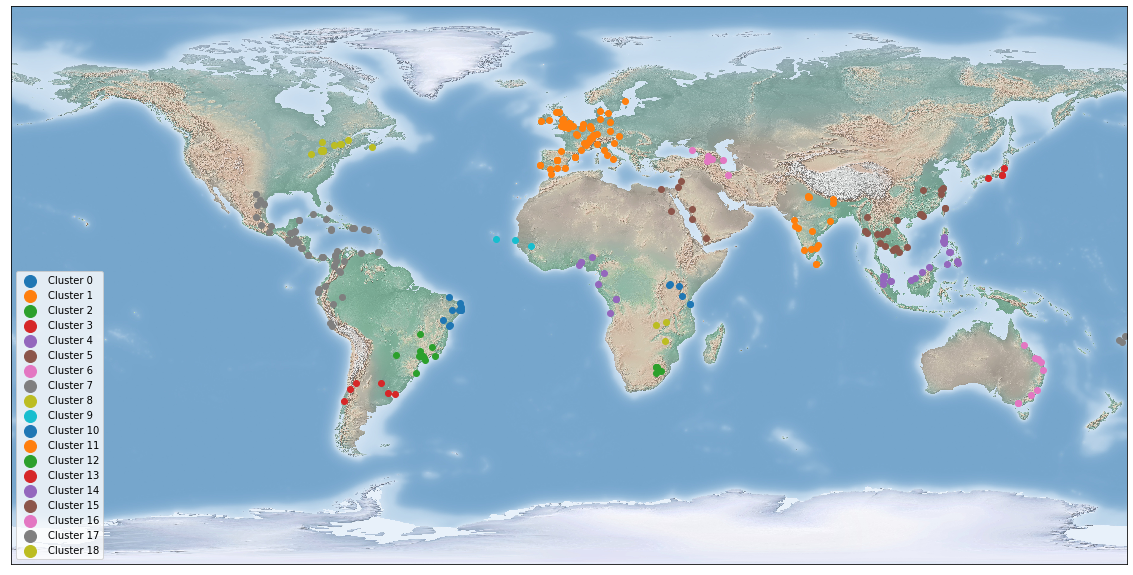

In [5]:
plot_clusters(df_world, world_plotter)
world_plotter.shadedrelief()
plt.show()

In [6]:
df_world.groupby('cluster').count().sort_values('headline', ascending=False)

headline  city  latitude  longitude  countrycode
cluster                                                  
 1             63    63        63         63           63
 7             56    56        56         56           56
 4             29    29        29         29           29
-1             26    26        26         26           26
 5             24    24        24         24           24
 11            16    16        16         16           16
 8             11    11        11         11           11
 2             11    11        11         11           11
 0             10    10        10         10           10
 6              9     9         9          9            9
 14             9     9         9          9            9
 15             7     7         7          7            7
 3              6     6         6          6            6
 10             6     6         6          6            6
 16             6     6         6          6            6
 12             5     5         5          5            5
 13             4     4         4          4            4
 17             3     3         3          3            3
 9              3     3         3          3            3
 18             3     3         3          3            3

# Re-clustering: United States

Now, its time to recluster our United States data. We're probably going to try different parameters here, since the distance between cities is much smaller.

In [7]:
EPS = 1.25
MIN_SAMPLES = 3
clusters = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit_predict(df_us[['latitude', 'longitude']].to_numpy())
df_us['cluster'] = clusters

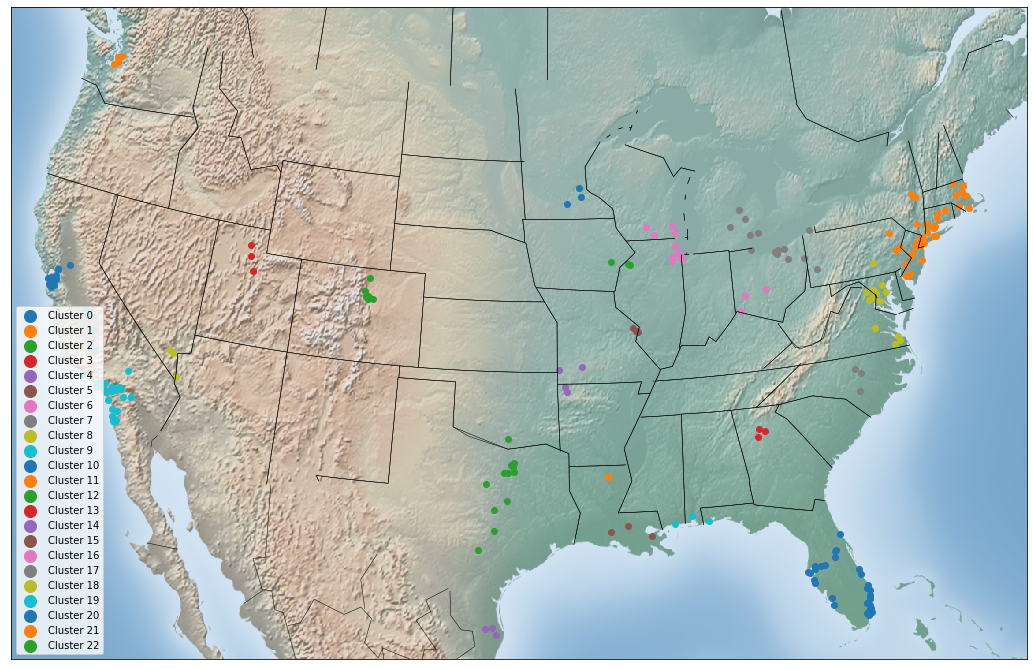

In [8]:
plot_clusters(df_us, us_plotter)
us_plotter.shadedrelief()
us_plotter.drawstates()
plt.show()

In [9]:
df_us.groupby('cluster').count().sort_values('headline', ascending=False)

headline  city  latitude  longitude  countrycode
cluster                                                  
-1             71    71        71         71           71
 1             42    42        42         42           42
 0             36    36        36         36           36
 9             32    32        32         32           32
 8             20    20        20         20           20
 7             14    14        14         14           14
 10            13    13        13         13           13
 2             12    12        12         12           12
 6              9     9         9          9            9
 12             7     7         7          7            7
 21             4     4         4          4            4
 14             4     4         4          4            4
 11             4     4         4          4            4
 5              3     3         3          3            3
 13             3     3         3          3            3
 4              3     3         3          3            3
 15             3     3         3          3            3
 16             3     3         3          3            3
 17             3     3         3          3            3
 18             3     3         3          3            3
 19             3     3         3          3            3
 20             3     3         3          3            3
 3              3     3         3          3            3
 22             3     3         3          3            3

# Finding Cluster Centers: Naïve Implementation

We'll find the center of each cluster for the US and World datasets, in order to locate headlines closet to the center of each cluster. For this verison, we'll do a simple average over all the Lat/Long points to represent the center.

In [10]:
us_centers_naive = {cluster_id: (np.mean(cluster.latitude), np.mean(cluster.longitude)) \
                             for cluster_id, cluster in df_us.groupby('cluster')}
world_centers_naive = {cluster_id: (np.mean(cluster.latitude), np.mean(cluster.longitude)) \
                             for cluster_id, cluster in df_world.groupby('cluster')}

In [11]:
# Based on the Haversine formula, found here: https://www.movable-type.co.uk/scripts/latlong.html
import math
def great_circle(point_1, point_2):
    RADIUS = 6371  # Kilometers, Earth's mean radius
    lat_1 = math.radians(point_1[0])
    lat_2 = math.radians(point_2[0])
    d_lat = lat_2 - lat_1
    d_long = math.radians(point_2[1] - point_1[1])
    a = math.sin(d_lat/2)**2 + math.cos(lat_1) * math.cos(lat_2) * math.sin(d_long/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return RADIUS * c

Next up, we'll create a new DataFrame to sort the headlines in each cluster by their proximity to the center we just calculated.

In [12]:
# TODO: Vectorize this...
# We'll do the US distances from their respective cluster centers first
dist_from_center = [great_circle((lat, lng), us_centers_naive[clust]) for lat, lng, clust \
                        in zip(df_us.latitude, df_us.longitude, df_us.cluster)]
df_us['dist_from_center'] = dist_from_center

# Next up are the world distances from their respective cluster centers
dist_from_center = [great_circle((lat, lng), world_centers_naive[clust]) for lat, lng, clust \
                        in zip(df_world.latitude, df_world.longitude, df_world.cluster)]
df_world['dist_from_center'] = dist_from_center

In [13]:
df_us.sort_values(by=['cluster', 'dist_from_center'], inplace=True)
df_world.sort_values(by=['cluster', 'dist_from_center'], inplace=True)

# Examining Headlines

With the data now sorted by closest point to the center of each cluster, we can now examine the data to see if there are trends of certain outbreaks in each cluster. From there, we can start noting common diseases.

In [14]:
known_diseases = set( ["Zika", r"Hepatitis [A-E]", "Mad Cow Disease"] )

In [15]:
pd.set_option('display.max_colwidth', -1)
df_us[(df_us.cluster == 22)]

headline         city  \
586  Davenport is infested with Dengue                   Davenport     
573  Will Gonorrhea vaccine help East Moline?            East Moline   
381  Iowa City Encounters Severe Symptoms of Rhinovirus  Iowa City     

     latitude  longitude countrycode  cluster  dist_from_center  
586  41.52364 -90.57764   US          22       23.120075         
573  41.50087 -90.44430   US          22       34.502385         
381  41.66113 -91.53017   US          22       57.556293

In [16]:
df_us[(df_us.headline.str.contains("Pneumonia"))]

headline           city  latitude  \
232  Benton Residents Recieve Pneumonia vaccine      Benton         34.56454   
402  Pneumonia Exposure in Alhambra                  Alhambra       33.49838   
425  Spike of Pneumonia Cases in The Bronx           The Bronx      40.84985   
510  Pneumonia Outbreak in Springville               Springville    40.16523   
131  Spike of Pneumonia Cases in Springfield         Springfield    37.21533   
284  How to Avoid Pneumonia in Bullhead City         Bullhead City  35.14778   
288  Pneumonia Symptoms Spread all over Bloomington  Bloomington    44.84080   

     longitude countrycode  cluster  dist_from_center  
232 -92.58683   US         -1        408.482194        
402 -112.13432  US         -1        1492.326792       
425 -73.86641   US          1        44.235552         
510 -111.61075  US          13       63.911342         
131 -93.29824   US          14       86.075658         
284 -114.56830  US          18       77.067962         
288 -93.29828   US          20       42.250632

To make our datasets easier to work with, we'll remove any unclustered headlines.

In [17]:
df_world = df_world[df_world.cluster != -1]
df_us = df_us[df_us.cluster != -1]

# Pinpointing Disease Outbreaks

Now that we've looked at each of the clusters and identified several frequently-occurring diseases, we'll now map the outbreaks of each disease.

In [18]:
MIN_OUTBREAKS = 10

## Pinpointing Disease Outbreaks: US Plotting

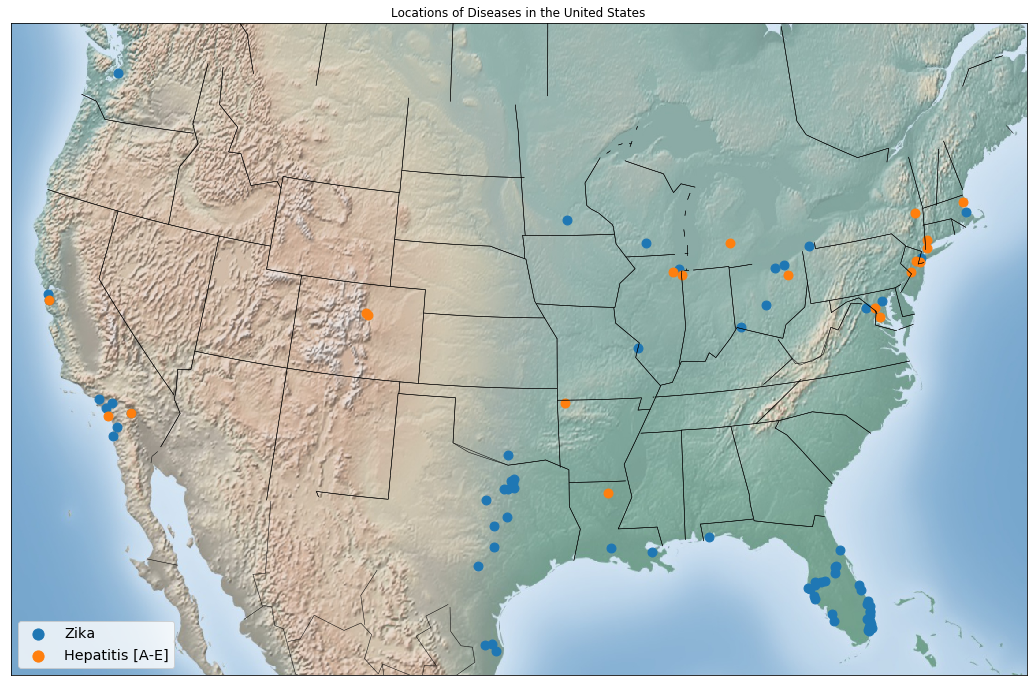

In [19]:
# US plotting
plt.figure(figsize=(20, 12))
included_diseases = []
for disease in known_diseases:
    disease_us = df_us[df_us['headline'].str.contains(disease)]
    if len(disease_us) < MIN_OUTBREAKS: continue  # Don't bother with small occurrences of diseases
    included_diseases.append(disease)
    us_plotter.scatter(disease_us.longitude.to_numpy(), disease_us.latitude.to_numpy(), latlon=True, s=80)
plt.title("Locations of Diseases in the United States")
us_plotter.shadedrelief()
us_plotter.drawstates()
plt.legend(included_diseases, loc="lower left", markerscale=1.25, fontsize="x-large")
plt.savefig(f"US_Disease_Map.png", dpi=300, orientation="landscape")

## Pinpointing Disease Outbreaks: World Plotting

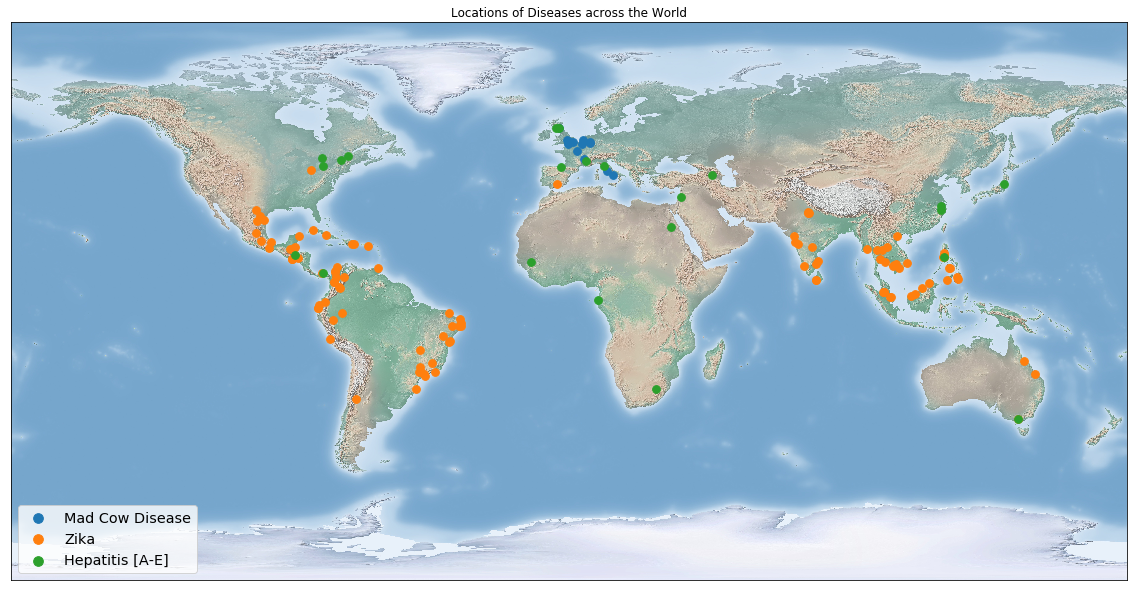

In [20]:
# World plotting
plt.figure(figsize=(20, 12))
included_diseases = []
for disease in known_diseases:
    disease_world = df_world[df_world['headline'].str.contains(disease)]
    if len(disease_world) < MIN_OUTBREAKS: continue  # Don't bother with small occurrences of diseases
    included_diseases.append(disease)
    world_plotter.scatter(disease_world.longitude.to_numpy(), disease_world.latitude.to_numpy(), latlon=True, s=60)
plt.title("Locations of Diseases across the World")
world_plotter.shadedrelief()
plt.legend(included_diseases, loc="lower left", markerscale=1.25, fontsize="x-large")
plt.savefig(f"World_Disease_Map.png", dpi=300, orientation="landscape")

With these maps in hand, it's clear that the world is facing a Zika pandemic, and action must be taken.